In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from bisect import bisect_left
from scipy import stats
import warnings

In [4]:
# trim 2 dataframes to match
def trim(dataframe_1, dataframe_2):
    def process(df):
        df.sort_index(inplace=True)
        temp = df.iloc[:,0].str.strip()
        df.drop(columns=df.columns[0], inplace = True)
        df.sort_index(axis=1, inplace=True)
        df.insert(0,temp.name,temp)
        return df
    
    df1 = process(dataframe_1.copy())
    df2 = process(dataframe_2.copy())
    
    # match indexes
    mask = df1.iloc[:, 0].isin(df2.iloc[:, 0])
    df1 = df1[mask]
    mask = df2.iloc[:, 0].isin(df1.iloc[:, 0])
    df2 = df2[mask]
    
    mask = df1.columns.str.strip().isin(df2.columns.str.strip())
    df1 = df1.loc[:, mask]
    mask = df2.columns.str.strip().isin(df1.columns.str.strip())
    df2 = df2.loc[:, mask]
    
    return df1, df2

def mut_trim(mutation, dataframe):
    df_out = dataframe.copy()
    df_out.iloc[:,0] = dataframe.iloc[:,0].str.strip()
    # initialize dataframe
    df = pd.DataFrame(columns = np.append(df_out.columns.str.strip(), 'throwaway'))
    df.iloc[:,0] = np.append(df_out.iloc[:,0], 'throwaway')
    df.iloc[:,1:] = 0
    
    # add mutations
    r = {key: i for i, key in enumerate(df.iloc[:, 0])}
    c = {key: i for i, key in enumerate(df.columns)}
    for i in range(len(mutation)): 
        df.iloc[r.get(mutation.iloc[i, 0], -1), c.get(mutation.iloc[i, -1], -1)] = 1
    
    return df.iloc[:-1, :-1], df_out

In [5]:
# normalize dataframe to 0
def normalize(matrix):
    mat = np.copy(matrix)
    mean = np.nanmean(matrix, axis=1)[:,np.newaxis]
    return mat-mean

In [6]:
def get_std(mat1, mat2):
    return np.nanstd(mat1), np.nanstd(mat2);

def avg_std(mat1, mat2):
    return math.sqrt((np.nanvar(mat1)+np.nanvar(mat2))/2)

In [18]:
# extracts a specific gene and creates density centers
# cutoff must exist to have density centers
def extract(df, name, cutoff=False, std=1, max=7, density_center=False, boxes=7):
    values = df[df.iloc[:, 0] == name].iloc[:, 1:].to_numpy()[0]

    if cutoff:
        # set values greater than max in graph to be max or values less than min in graph to be min
        # values[values > std*max] = std*max
        # values[values < -std*max] = -std*max
        pass
    else:
        return values

    if density_center:
        centers = np.linspace(-std*max, std*max, num=boxes*2, endpoint=False)[1::2]
        return values, centers
    else:
        return values

In [8]:
# extracts a specific gene and creates density centers for static_dfation data
def drop_nan(x, y):
    combined = np.array(np.concatenate(([x],[y]), axis=0))
    # drop NaN
    combined = combined[:, ~pd.isna(combined).any(axis=0)]

    return combined[0], combined[1]

In [9]:
# convert 2 vectors into a heatmap
def densitymap(x, y, xDensityCenters, yDensityCenters, xdiscrete=False, ydiscrete=False, sigma=1):
    if len(x) != len(y):
        return "inconsistent size of x and y vectors"
    
    sigma_sq_inv = (1/sigma)**2
    mat = np.zeros((len(yDensityCenters), len(xDensityCenters)))

    if not xdiscrete and not ydiscrete:
        for pt in range(len(x)):
            temp = np.zeros((len(yDensityCenters), len(xDensityCenters)))
            for i, center_x in enumerate(xDensityCenters):
                for j, center_y in enumerate(yDensityCenters):
                    dist_sq = (x[pt] - center_x)**2+(y[pt] - center_y)**2
                    temp[j, i] = np.exp(-0.5*sigma_sq_inv*dist_sq)
                    
            temp /= np.sum(temp)
            mat += temp
            
    elif xdiscrete and ydiscrete:
        for i, center_x in enumerate(xDensityCenters):
            for j, center_y in enumerate(yDensityCenters):
                mat[j, i] += np.sum((x[y==center_y]==center_x))
                
    elif xdiscrete:
        for pt in range(len(x)):
            temp = np.zeros(len(yDensityCenters))
            for i, center_y in enumerate(yDensityCenters):
                dist_sq = (y[pt] - center_y)**2
                temp[i] = np.exp(-0.5*sigma_sq_inv*dist_sq)
                    
            temp /= np.sum(temp)
            mat[:, xDensityCenters.index(x[pt])] += temp
    else:
        for pt in range(len(y)):
            temp = np.zeros(len(xDensityCenters))
            for i, center_x in enumerate(xDensityCenters):
                dist_sq = (x[pt] - center_x)**2
                temp[i] = np.exp(-0.5*sigma_sq_inv*dist_sq)
                    
            temp /= np.sum(temp)
            mat[yDensityCenters.index(y[pt])] += temp
    
    # Normalize the kernel
    mat /= len(x)
    
    return mat

In [10]:
# Convert your data into multiple visual heatmaps
# data: an array of numbers
# dimensions: a multi-dimensional array with pairs indicating the different dimensions
def heatmap(data, dimensions, cmap='hot', min=None, max=None, flip=False):
    index = 0
    for dim in dimensions:
        mat = np.reshape(data[index:index+dim[0]*dim[1]], (dim[0],dim[1]))
        if flip:
            mat = np.flip(mat, 0)
        if min != None and max != None:
            im = plt.imshow(mat, cmap=cmap, interpolation='nearest', vmin=min, vmax=max)
        else:
            im = plt.imshow(mat, cmap=cmap, interpolation='nearest')
        plt.colorbar(im)
        plt.show()
        index += dim[0]*dim[1]

In [13]:
gene_exp = pd.read_csv(r"/home/hxu/CCLE_ML_project/CCLE_ML_project/Data/DepMap_data/CCLE_gene_expression_trimmed_Wei.csv")
gene_exp.name = 'gene_exp'

copy_num = pd.read_csv(r"/home/hxu/CCLE_ML_project/CCLE_ML_project/Data/DepMap_data/CCLE_gene_cn_trimmed_Wei.csv")
copy_num.iloc[:,1:] *= 2
copy_num_o = copy_num.copy()
def take_closest(myList, myNumber):
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before 
# List of values to compare for each element in the DataFrame
values_to_compare = [0, 1, 2, 3, 4, 6, 8]
# Apply the take_closest function to every value in the DataFrame
copy_num.iloc[:,1:] = copy_num.iloc[:,1:].map(lambda x: take_closest(values_to_compare, x))
copy_num.name = 'copy_num'

shRNA = pd.read_csv(r"/home/hxu/CCLE_ML_project/CCLE_ML_project/Data/DepMap_data/shRNA_Broad_Trimmed_Wei.csv")
shRNA.name = 'shRNA'

gene_mut = pd.read_csv(r"/home/hxu/CCLE_ML_project/CCLE_ML_project/Data/DepMap_data/CCLE_gene_mutation_trimmed_Wei.csv")
gene_mut.drop(columns=gene_mut.columns[0],inplace=True)
gene_mut.name = 'gene_mut'

CRISPR = pd.read_csv(r"/home/hxu/CCLE_ML_project/CCLE_ML_project/Data/DepMap_data/Avana_gene_effect_20Q3_Trimmed_Wei.csv")
CRISPR.name = 'CRISPR'

/tmp/ipykernel_67812/3356504097.py:28: DtypeWarning: Columns (20,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_mut = pd.read_csv(r"/home/hxu/CCLE_ML_project/CCLE_ML_project/Data/DepMap_data/CCLE_gene_mutation_trimmed_Wei.csv")


In [14]:
gene_name = 'BRAF'

# Gene Expression & shRNA

In [12]:
gene_exp_rna, shRNA_ge = trim(gene_exp, shRNA)
gene_exp_rna.iloc[:,1:] = normalize(gene_exp_rna.iloc[:,1:])
shRNA_ge.iloc[:,1:] = normalize(shRNA_ge.iloc[:,1:])
gene_exp_rna_std, shRNA_ge_std = get_std(gene_exp_rna.iloc[:,1:].to_numpy(), shRNA_ge.iloc[:,1:].to_numpy())

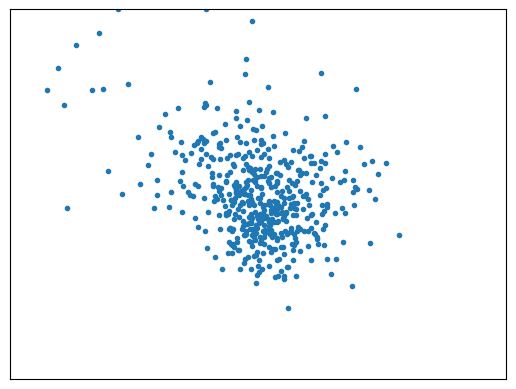

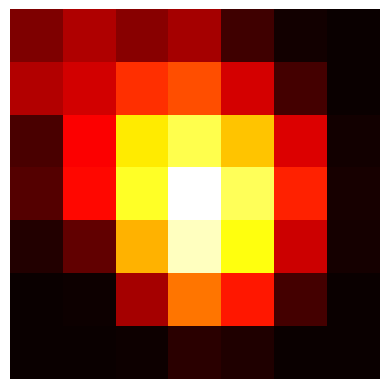

In [13]:
x, xd = extract(gene_exp_rna, gene_name, cutoff=True, std=gene_exp_rna_std, max=7, density_center=True, boxes=7)
y, yd = extract(shRNA_ge, gene_name, cutoff=True, std=shRNA_ge_std, max=7, density_center=True, boxes=7)
std = avg_std(gene_exp_rna.iloc[:,1:].to_numpy(), shRNA_ge.iloc[:,1:].to_numpy())
mat = np.flip(densitymap(x, y, xd, yd, sigma=std), 0)
mat += 1/len(gene_exp_rna.columns)

# show scatterplot
plt.scatter(x,y,marker='.')
plt.axis((-7*gene_exp_rna_std, 7*gene_exp_rna_std, -7*shRNA_ge_std, 7*shRNA_ge_std))
plt.xticks([])
plt.yticks([])
plt.show()
# show heatmap
plt.imshow(mat, cmap='hot', norm='log')
plt.axis('off')
plt.show()

# Mutation & CRISPR

In [15]:
gene_mut_cr, CRISPR_gm = mut_trim(gene_mut, CRISPR)
CRISPR_gm.iloc[:,1:] = normalize(CRISPR_gm.iloc[:,1:])
CRISPR_gm_std = np.nanstd(CRISPR_gm.iloc[:,1:])

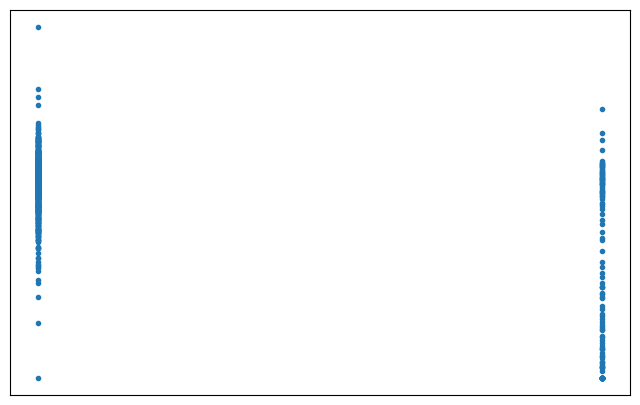

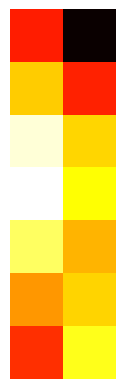

In [16]:
x = extract(gene_mut_cr, gene_name, cutoff=False)
y, yd = extract(CRISPR_gm, gene_name, cutoff=True, std=CRISPR_gm_std, max=7, density_center=True, boxes=7)
x, y = drop_nan(x, y)
mat = np.flip(densitymap(x, y, [0, 1], yd, xdiscrete=True, sigma=CRISPR_gm_std), 0)

# show scatterplot
plt.figure(figsize=(8,5))
plt.scatter(x,y,marker='.')
plt.xticks([])
plt.yticks([])
plt.show()
# show heatmap
plt.imshow(mat, cmap='hot', norm='log')
plt.axis('off')
plt.show()

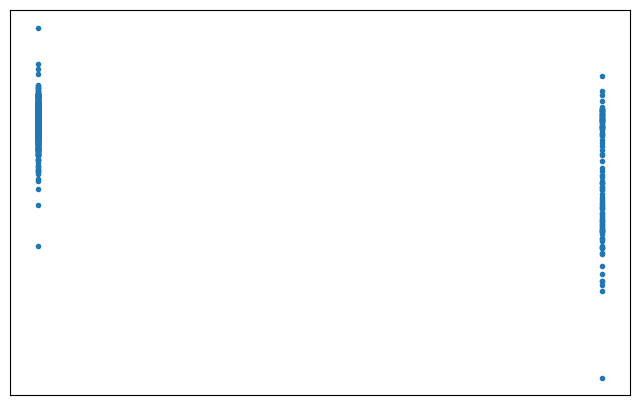

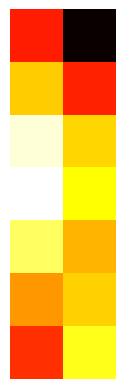

In [19]:
x = extract(gene_mut_cr, gene_name, cutoff=False)
y, yd = extract(CRISPR_gm, gene_name, cutoff=True, std=CRISPR_gm_std, max=7, density_center=True, boxes=7)
x, y = drop_nan(x, y)
mat = np.flip(densitymap(x, y, [0, 1], yd, xdiscrete=True, sigma=CRISPR_gm_std), 0)

# show scatterplot
plt.figure(figsize=(8,5))
plt.scatter(x,y,marker='.')
plt.xticks([])
plt.yticks([])
plt.show()
# show heatmap
plt.imshow(mat, cmap='hot', norm='log')
plt.axis('off')
plt.show()

# Gene Expression & Copy Number

In [23]:
copy_num_cr, CRISPR_cn = trim(copy_num, gene_exp)
copy_num_cr_o, _ = trim(copy_num_o, gene_exp)
CRISPR_cn.iloc[:,1:] = normalize(CRISPR_cn.iloc[:,1:])
CRISPR_cn_std = np.nanstd(CRISPR_cn.iloc[:,1:])

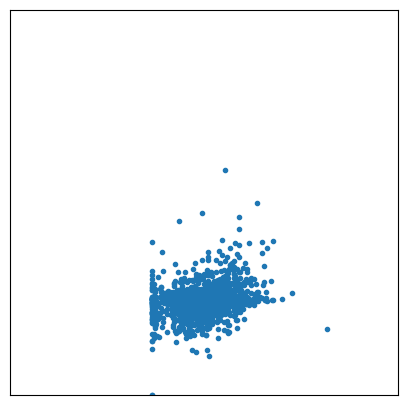

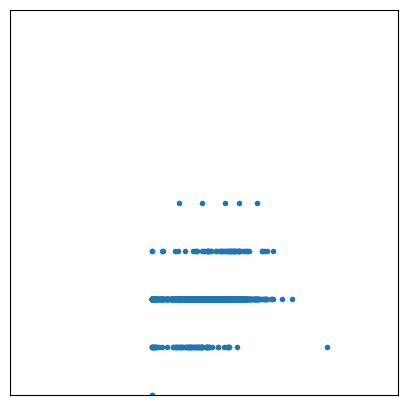

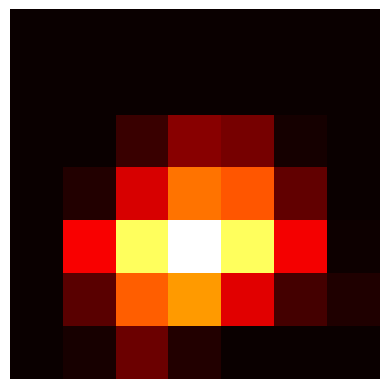

In [39]:
x, xd = extract(CRISPR_cn, gene_name, cutoff=True, std=CRISPR_cn_std, max=7, density_center=True, boxes=7)
y = extract(copy_num_cr, gene_name, cutoff=False)
y_scatter = extract(copy_num_cr_o, gene_name, cutoff=False)
x, y = drop_nan(x, y)
mat = np.flip(densitymap(x,y,xd,[0,1,2,3,4,6,8], ydiscrete=True, sigma=CRISPR_cn_std), 0)
mat += 1/len(CRISPR_cn.columns)

# show scatterplot
plt.figure(figsize=(5,5))
plt.scatter(x,y_scatter,marker='.')
plt.axis((-7*CRISPR_cn_std, 7*CRISPR_cn_std, 0, 8))
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(x,y,marker='.')
plt.axis((-7*CRISPR_cn_std, 7*CRISPR_cn_std, 0, 8))
plt.xticks([])
plt.yticks([])
plt.show()
# show heatmap
plt.imshow(mat, cmap='hot', norm='log')
plt.axis('off')
plt.show()